# Evaluate and fit a ML model on the EC flux tower data 

Need to better consider categorical Landcover data. Currrently just passing it as integers in a single column. I can use one-hot-encoding but this may be a poor way of handling categorical variables in this case:
* https://notebook.community/roaminsight/roamresearch/BlogPosts/Categorical_variables_in_tree_models/categorical_variables_post
* https://notebook.community/marcotcr/lime/doc/notebooks/Tutorial_H2O_continuous_and_cat

* I should consider using `h2o` which handles categorical data much better https://www.kaggle.com/code/nanomathias/h2o-distributed-random-forest-starter/script
* R's randomforest algos do a better job too

* `LightGBM` handles categorical variables well: https://lightgbm.readthedocs.io/en/latest/Features.html#optimal-split-for-categorical-features


## Load modules

In [1]:
import os
import shap
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sb
from joblib import dump
import multiprocessing
from pprint import pprint
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, ShuffleSplit, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings("ignore")

## Analysis Parameters

In [2]:
model_name = 'AUS'
model_var = 'ER'

In [3]:
ncpus=multiprocessing.cpu_count()
print('ncpus = '+str(ncpus))

ncpus = 16


## Prepare Data

In [4]:
base = '/g/data/os22/chad_tmp/NEE_modelling/results/training_data/'
sites = os.listdir('/g/data/os22/chad_tmp/NEE_modelling/results/training_data/')

td = []
for site in sites:
    if '.csv' in site:
        xx = pd.read_csv(base+site, index_col='time', parse_dates=True)
        td.append(xx)

## Modelling

In [5]:
xx = []
yy = []
for t in td:
    #t = t.drop('soil_moisture_RS', axis=1) # get rid of soil moisture 
    t = t.dropna()  # remove NaNS
    df = t.drop(['NEE_SOLO_EC','GPP_SOLO_EC','ER_SOLO_EC'], axis=1) # seperate carbon fluxes
    df = df.filter(regex='RS') # only use remote sensing variables   
    
    # Write out predictior variables to text file
    textfile = open("/g/data/os22/chad_tmp/NEE_modelling/results/variables.txt", "w")
    for element in df.columns:
        textfile.write(element + ",")
    textfile.close()
    
    df_var=t[model_var+'_SOLO_EC'] # seperate out the variable we're modelling

    x = df.reset_index(drop=True)#.to_numpy()
    y = df_var.reset_index(drop=True)#.to_numpy()
    xx.append(x)
    yy.append(y)

x = np.concatenate([x for x in xx])
y = np.concatenate([y for y in yy])

print(x.shape)

(2100, 12)


## One-hot Encoding of LC class

Need to reprocess the gridded landcover dataset into four binary gridded datasets (one for trees, crops, etc), this way the one-hot-encoding isn't required since the training data extraction will extract binary variables for each LC class.

In [6]:
# df_xx = pd.concat(xx)
# df_yy = pd.concat(yy)

# df_xx['PFT_RS'] = np.where(df_xx['PFT_RS']==10.0, 'Trees', df_xx['PFT_RS'])
# df_xx['PFT_RS'] = np.where(df_xx['PFT_RS']=='20.0', 'Shrubs', df_xx['PFT_RS'])
# df_xx['PFT_RS'] = np.where(df_xx['PFT_RS']=='30.0', 'Grass', df_xx['PFT_RS'])
# df_xx['PFT_RS'] = np.where(df_xx['PFT_RS']=='40.0', 'Crops', df_xx['PFT_RS'])


# from sklearn.preprocessing import OneHotEncoder
# one_hot = OneHotEncoder()
# encoded = one_hot.fit_transform(df_xx[['PFT_RS']])
# df_xx[one_hot.categories_[0]] = encoded.toarray()

# x = df_xx.to_numpy()
# y = df_yy.to_numpy()

## Test model robustness with nested K-fold cross validation

In [7]:
inner_cv_splits = 5

outer_cv_splits = 5

test_size = 0.20

In [8]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'criterion': ["squared_error", "absolute_error"],
    'max_features': ['auto', 'log2', None],
    'n_estimators': [200,300,400]
}

In [9]:
outer_cv = KFold(n_splits=outer_cv_splits, shuffle=True,
                        random_state=0)

# lists to store results of CV testing
acc = []
rmse=[]
r2=[]
i = 1
for train_index, test_index in outer_cv.split(x, y):
    print(f"Working on {i}/5 outer cv split", end='\r')
    model = RandomForestRegressor(random_state=1, n_jobs=ncpus)

    # index training, testing, and coordinate data
    X_tr, X_tt = x[train_index, :], x[test_index, :]
    y_tr, y_tt = y[train_index], y[test_index]
    
    # inner split on data within outer split
    inner_cv = KFold(n_splits=inner_cv_splits,
                     shuffle=True,
                     random_state=0)
    
    clf = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='r2',
        n_jobs=ncpus,
        refit=True,
        cv=inner_cv.split(X_tr, y_tr),
    )

    clf.fit(X_tr, y_tr)
    # predict using the best model
    best_model = clf.best_estimator_
    pred = best_model.predict(X_tt)

    # evaluate model w/ multiple metrics
    # r2
    r2_ = r2_score(y_tt, pred)
    r2.append(r2_)
    # Overall accuracy
    ac = mean_absolute_error(y_tt, pred)
    acc.append(ac)
    # F1 scores
    rmse_ = np.sqrt(mean_squared_error(y_tt, pred))
    rmse.append(rmse_)
    i += 1

In [10]:
print("Mean MAE accuracy: "+ str(round(np.mean(acc), 2)))
print("Std dev of MAE accuracy: "+ str(round(np.std(acc), 2)))
print('\n')
print("Mean RMSE: "+ str(round(np.mean(rmse), 2)))
print("Std dev RMSE: "+ str(round(np.std(rmse), 2)))
print('\n')
print("Mean r2: "+ str(round(np.mean(r2), 2)))
print("Std dev r2: "+ str(round(np.std(r2), 2)))

Mean MAE accuracy: 16.7
Std dev of MAE accuracy: 0.67


Mean RMSE: 26.94
Std dev RMSE: 1.33


Mean r2: 0.78
Std dev r2: 0.02


## Optimize hyperparameters

In [11]:
#generate n_splits of train-test_split
rs = ShuffleSplit(n_splits=outer_cv_splits, test_size=test_size, random_state=1)

#instatiate a gridsearchCV
clf = GridSearchCV(RandomForestRegressor(),
                   param_grid,
                   scoring='r2',
                   verbose=1,
                   cv=rs.split(x, y),
                   n_jobs=ncpus)

clf.fit(x, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=<generator object BaseShuffleSplit.split at 0x7f209c42f350>,
             estimator=RandomForestRegressor(), n_jobs=16,
             param_grid={'criterion': ['squared_error', 'absolute_error'],
                         'max_features': ['auto', 'log2', None],
                         'n_estimators': [200, 300, 400]},
             scoring='r2', verbose=1)

In [12]:
print("The most accurate combination of tested parameters is: ")
pprint(clf.best_params_)
print('\n')
print("The r2 score using these parameters is: ")
print(round(clf.best_score_, 2))

The most accurate combination of tested parameters is: 
{'criterion': 'squared_error', 'max_features': None, 'n_estimators': 300}


The r2 score using these parameters is: 
0.78


## Fit on all data using best params

In [13]:
model = RandomForestRegressor(**clf.best_params_, random_state=1, n_jobs=ncpus)
model.fit(x, y)

RandomForestRegressor(max_features=None, n_estimators=300, n_jobs=16,
                      random_state=1)

## Examine feature importance

SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model

https://github.com/slundberg/shap

https://towardsdatascience.com/explaining-scikit-learn-models-with-shap-61daff21b12a

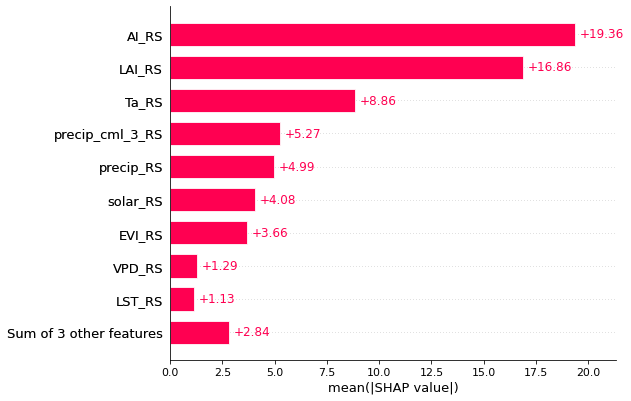

In [14]:
# explain the model's predictions using SHAP
explainer = shap.Explainer(model)
shap_values = explainer(x)

#add names of features
shap_values.feature_names = df.columns.values

# visualize the importances
# shap.plots.waterfall(shap_values[0])
# shap.plots.beeswarm(shap_values)
shap.plots.bar(shap_values)

## Save the model

In [16]:
dump(model, '/g/data/os22/chad_tmp/NEE_modelling/results/models/'+model_name+'_'+model_var+'_RF_model.joblib')

['/g/data/os22/chad_tmp/NEE_modelling/results/models/AUS_ER_RF_model.joblib']

## Predict on all the data

In [17]:
y_pred = model.predict(x)

rmse = float(format(np.sqrt(mean_squared_error(y, y_pred)), '.3f'))
print("RMSE:", rmse);

RMSE: 13.366


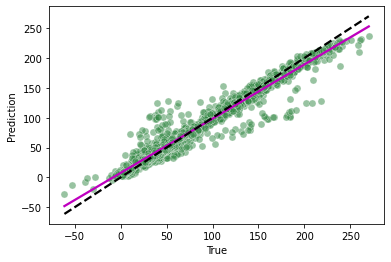

In [18]:
sb.scatterplot(x=y,y=y_pred,color="#338844", edgecolor="white", s=50, lw=1, alpha=0.5)
sb.regplot(x=y, y=y_pred, scatter=False, color='m')
sb.regplot(x=y, y=y, color='black', scatter=False, line_kws={'linestyle':'dashed'});
plt.xlabel('True')
plt.ylabel('Prediction');